In [1]:
# Load necessary libraries
library(xgboost)
library(caret)
library(dplyr)
library(imager)
library(EBImage)  # For bwlabel and shape feature extraction
library(ggplot2)
library(e1071)  # For skewness and kurtosis

# Set the path to your dataset
data_dir <- "/kaggle/input/leukemia-images/Original"

# Define image size and parameters
img_height <- 150
img_width <- 150
batch_size <- 32  # Note: batch_size is defined but not used in the code

# Create a list to hold all file paths and corresponding labels
file_paths <- character()  # More explicit initialization
class_labels <- character()

# Loop through each class to gather file paths and labels
for (class in c("Benign", "Early", "Pre", "Pro")) {
  class_path <- file.path(data_dir, class)
  
  # Add error handling for directory access
  if (!dir.exists(class_path)) {
    stop(paste("Directory not found:", class_path))
  }
  
  files <- list.files(class_path, full.names = TRUE, pattern = "\\.(?i)(jpg|jpeg|png|tiff)$")
  
  # Ensure files are unique
  unique_files <- unique(files)
  
  file_paths <- c(file_paths, unique_files)
  class_labels <- c(class_labels, rep(class, length(unique_files)))
}

# Create a DataFrame with only the required structure
full_df <- data.frame(
  image_filename = file_paths,
  class = factor(class_labels, levels = c("Benign", "Early", "Pre", "Pro")),
  stringsAsFactors = FALSE
)

# Define class-to-index mapping
classes <- c("Benign", "Early", "Pre", "Pro")
class_to_index <- setNames(0:(length(classes) - 1), classes)

# Add numeric class column (0-based indexing)
full_df$class_numeric <- as.numeric(full_df$class) - 1

# Stratified split into training (64%), validation (20%), and test (16%) sets
set.seed(123)
trainIndex <- createDataPartition(full_df$class, p = 0.64, list = FALSE)
train_df <- full_df[trainIndex, ]
remaining_df <- full_df[-trainIndex, ]

# Shuffle only train_df
train_df <- train_df[sample(nrow(train_df)), ]

validationIndex <- createDataPartition(remaining_df$class, p = 20/36, list = FALSE)
val_df <- remaining_df[validationIndex, ]
test_df <- remaining_df[-validationIndex, ]

# Calculate class weights using only the training dataset
n_samples <- nrow(train_df)  
n_classes <- length(unique(train_df$class))

# Get class frequencies from training dataset
class_counts <- table(train_df$class_numeric)

# Calculate balanced weights
class_weights <- n_samples / (n_classes * class_counts)

# Convert to a named list with numeric indices as names
class_weights <- as.list(class_weights)
names(class_weights) <- as.character(0:(n_classes-1))

# Print diagnostics
cat("\nClass distribution in training dataset:\n")
print(table(train_df$class))

cat("\nFinal Class Weights (based on training dataset):\n")
print(class_weights)

# Validation steps
cat("\nValidation:\n")
cat("Total samples in training dataset:", n_samples, "\n")
cat("Sum of class counts:", sum(class_counts), "\n")
cat("Number of classes:", n_classes, "\n")
cat("Maximum weight ratio:", max(unlist(class_weights)) / min(unlist(class_weights)), "\n\n")

# Additional validation checks
cat("Verification of weight calculation:\n")
for(i in 0:(n_classes-1)) {
  class_name <- classes[i+1]
  weight <- class_weights[[as.character(i)]]
  count <- class_counts[as.character(i)]
  cat(sprintf("%s: count=%d, weight=%.4f, count*weight=%.4f\n", 
              class_name, count, weight, count*weight))
}

# Features extraction function 
extract_features <- function(image_path, bins = 16, feature_params = NULL) {
  # Load and resize the image using imager
  image <- load.image(image_path)
  image <- resize(image, img_width, img_height)
  
  # Convert image to array and split into color channels
  red_channel <- as.vector(image[,,1,1])
  green_channel <- as.vector(image[,,1,2])
  blue_channel <- as.vector(image[,,1,3])
  
  # Color histogram features for each channel
  red_hist <- hist(red_channel, breaks = bins, plot = FALSE)$counts / length(red_channel)
  green_hist <- hist(green_channel, breaks = bins, plot = FALSE)$counts / length(green_channel)
  blue_hist <- hist(blue_channel, breaks = bins, plot = FALSE)$counts / length(blue_channel)
  
  # Convert to grayscale for texture and edge features
  gray_image <- 0.299 * red_channel + 0.587 * green_channel + 0.114 * blue_channel
  
  # Texture features: contrast, skewness, and kurtosis
  contrast <- var(gray_image)
  skewness <- e1071::skewness(gray_image)
  kurtosis <- e1071::kurtosis(gray_image)
  
  # Statistical descriptors
  mean_intensity <- mean(gray_image)
  sd_intensity <- sd(gray_image)
  max_intensity <- max(gray_image)
  min_intensity <- min(gray_image)
  
  # Edge detection using gradient magnitude approximation (Sobel-like)
  gray_img_cimg <- as.cimg(gray_image, x = img_width, y = img_height)
  grad_x <- imgradient(gray_img_cimg, "x")
  grad_y <- imgradient(gray_img_cimg, "y")
  edge_magnitude <- sqrt(grad_x^2 + grad_y^2)  # Approximate edge strength
  edge_intensity_mean <- mean(edge_magnitude)
  edge_intensity_sd <- sd(edge_magnitude)
  
  # Shape features using segmentation (using EBImage)
  gray_img_matrix <- matrix(gray_image, nrow = img_height, ncol = img_width)
  binary_image <- gray_img_matrix > 0.5  # Apply threshold to get binary mask
  binary_image <- as.Image(binary_image)  # Convert to EBImage object
  
  # Label the binary image
  labeled_image <- bwlabel(binary_image)
  
  # Compute shape features
  shape_features <- computeFeatures.shape(labeled_image)
  
  # Shape descriptors - Mean values of area, perimeter, and circularity
  area_mean <- mean(shape_features[,"s.area"], na.rm = TRUE)
  perimeter_mean <- mean(shape_features[,"s.perimeter"], na.rm = TRUE)
  circularity_mean <- mean((4 * pi * shape_features[,"s.area"]) / (shape_features[,"s.perimeter"]^2), na.rm = TRUE)
  
  # Combine all features into a single vector
  feature_vector <- c(red_hist, green_hist, blue_hist, contrast, skewness, kurtosis, 
                      mean_intensity, sd_intensity, max_intensity, min_intensity,
                      edge_intensity_mean, edge_intensity_sd,
                      area_mean, perimeter_mean, circularity_mean)
  
  return(feature_vector)
}

# Function to analyze feature lengths across training data
get_feature_params <- function(train_image_paths, sample_size = NULL) {
  # If sample_size is provided, randomly sample images for efficiency
  if (!is.null(sample_size) && sample_size < length(train_image_paths)) {
    set.seed(123)  # for reproducibility
    image_paths <- sample(train_image_paths, sample_size)
  } else {
    image_paths <- train_image_paths
  }
  
  cat("Analyzing features from", length(image_paths), "training images...\n")
  
  # Extract features from all training images and analyze
  feature_lengths <- sapply(image_paths, function(path) {
    tryCatch({
      features <- extract_features(path)
      length(features)
    }, error = function(e) {
      warning(sprintf("Error processing image %s: %s", path, e$message))
      return(NA)
    })
  })
  
  # Analyze feature length distribution
  length_summary <- summary(feature_lengths)
  length_table <- table(feature_lengths)
  
  # Check for inconsistencies
  if (length(unique(feature_lengths[!is.na(feature_lengths)])) > 1) {
    warning("Inconsistent feature lengths detected in training data!")
    print(length_table)
    print(length_summary)
  }
  
  # Get most common feature length (mode)
  modal_length <- as.numeric(names(length_table)[which.max(length_table)])
  
  # Get feature names from a successful extraction
  sample_features <- NULL
  for (path in image_paths) {
    tryCatch({
      sample_features <- extract_features(path)
      if (length(sample_features) == modal_length) break
    }, error = function(e) {
      next
    })
  }
  
  params <- list(
    feature_length = modal_length,
    feature_names = paste0("feature_", seq_len(modal_length)),
    length_distribution = length_table,
    length_summary = length_summary,
    sample_size = length(image_paths),
    success_rate = sum(!is.na(feature_lengths)) / length(feature_lengths),
    consistent_length = length(unique(feature_lengths[!is.na(feature_lengths)])) == 1
  )
  
  # Print summary
  cat("\nFeature extraction analysis summary:\n")
  cat("Modal feature length:", params$feature_length, "\n")
  cat("Success rate:", sprintf("%.2f%%", params$success_rate * 100), "\n")
  cat("Length consistency:", ifelse(params$consistent_length, "Consistent", "Inconsistent"), "\n")
  
  if (!params$consistent_length) {
    cat("\nFeature length distribution:\n")
    print(params$length_distribution)
  }
  
  return(params)
}

# Modified feature extraction pipeline
set.seed(123)  # for reproducibility

# Step 1: Get feature parameters from training data
# Option to sample if training set is very large
sample_size <- if(nrow(train_df) > 1000) 1000 else NULL
feature_params <- get_feature_params(train_df$image_filename, sample_size)

# Enhanced feature extraction function with validation
extract_and_validate_features <- function(image_paths, feature_params, dataset_name) {
  features_list <- lapply(seq_along(image_paths), function(i) {
    path <- image_paths[i]
    
    if (i %% 100 == 0) {
      cat(sprintf("Processing %s image %d of %d\n", 
                 dataset_name, i, length(image_paths)))
    }
    
    tryCatch({
      features <- extract_features(path)
      
      # Validate feature length
      if (length(features) != feature_params$feature_length) {
        
        # Handle inconsistent length
        if (length(features) < feature_params$feature_length) {
          # Pad with NA if shorter
          features <- c(features, rep(NA, feature_params$feature_length - length(features)))
        } else {
          # Truncate if longer
          features <- features[1:feature_params$feature_length]
        }
      }
      
      return(features)
      
    }, error = function(e) {
      warning(sprintf("Error processing %s image %s: %s", 
                     dataset_name, path, e$message))
      return(rep(NA, feature_params$feature_length))
    })
  })
  
  # Convert to matrix/data frame
  features_matrix <- do.call(rbind, features_list)
  colnames(features_matrix) <- feature_params$feature_names
  
  # Report statistics about NA values
  na_counts <- colSums(is.na(features_matrix))
  if (any(na_counts > 0)) {
    cat("\nNA counts in", dataset_name, "dataset:\n")
    print(na_counts[na_counts > 0])
  }
  
  return(features_matrix)
}

# Extract features for each dataset
cat("\nExtracting training features...\n")
train_features <- extract_and_validate_features(
  train_df$image_filename, 
  feature_params,
  "training"
)

cat("\nExtracting validation features...\n")
val_features <- extract_and_validate_features(
  val_df$image_filename, 
  feature_params,
  "validation"
)

cat("\nExtracting test features...\n")
test_features <- extract_and_validate_features(
  test_df$image_filename, 
  feature_params,
  "test"
)

# Ensure that class labels are factors with consistent levels
train_df$class <- factor(train_df$class, levels = c("Benign", "Early", "Pre", "Pro"))
test_df$class <- factor(test_df$class, levels = c("Benign", "Early", "Pre", "Pro"))
val_df$class <- factor(val_df$class, levels = c("Benign", "Early", "Pre", "Pro"))

train_data <- cbind(as.data.frame(train_features), class_numeric = train_df$class_numeric)
validation_data <- cbind(as.data.frame(val_features), class_numeric = val_df$class_numeric)
test_data <- cbind(as.data.frame(test_features), class_numeric = test_df$class_numeric)

train_data[is.na(train_data)] <- 0
validation_data[is.na(validation_data)] <- 0
test_data[is.na(test_data)] <- 0

# Convert class_numeric to factor with proper labels for training and testing
train_data$class <- factor(train_data$class_numeric, 
                                levels = 0:3, 
                                labels = classes)
validation_data$class <- factor(validation_data$class_numeric, 
                                     levels = 0:3, 
                                     labels = classes)
test_data$class <- factor(test_data$class_numeric, 
                                levels = 0:3, 
                                labels = classes)

library(caret)
library(e1071)


# Function to identify NZV features from training data
identify_nzv_features <- function(train_data) {
  nzv <- nearZeroVar(train_data, saveMetrics = TRUE)
  nzv_features <- rownames(nzv)[nzv$zeroVar | nzv$nzv]
  
  # Log the features being removed and their properties
  cat("Features removed due to near-zero variance:\n")
  for(feature in nzv_features) {
    cat(sprintf("Feature: %s, Variance: %.6f\n", 
                feature, 
                var(train_data[[feature]], na.rm = TRUE)))
  }
  
  return(nzv_features)
}

# Function to check for differences in feature variance between datasets
check_feature_variance <- function(train_data, val_data, test_data, nzv_features) {
  warning_features <- list()
  
  for(feature in nzv_features) {
    if(feature %in% names(val_data) && feature %in% names(test_data)) {
      train_var <- var(train_data[[feature]], na.rm = TRUE)
      val_var <- var(val_data[[feature]], na.rm = TRUE)
      test_var <- var(test_data[[feature]], na.rm = TRUE)
      
      # Check if feature has significant variance in validation or test
      if(val_var > 0.1 || test_var > 0.1) {  # Threshold can be adjusted
        warning_features[[feature]] <- list(
          train_variance = train_var,
          val_variance = val_var,
          test_variance = test_var
        )
      }
    }
  }
  
  return(warning_features)
}

# Apply the fixed NZV filtering process
# First, identify NZV features from training data only
nzv_features <- identify_nzv_features(train_data[, -ncol(train_data)])

# Check for potential issues in validation and test sets
variance_warnings <- check_feature_variance(
  train_data[, -ncol(train_data)],
  validation_data[, -ncol(validation_data)],
  test_data[, -ncol(test_data)],
  nzv_features
)

# Print warnings if any features show different behavior in val/test
if(length(variance_warnings) > 0) {
  cat("\nWARNING: Some features show different variance patterns in validation/test sets:\n")
  print(variance_warnings)
  cat("\nConsider keeping these features in the model.\n")
}

# Remove NZV features and 'class_numeric' from all datasets
train_data_filtered <- train_data[, !names(train_data) %in% c(nzv_features, "class_numeric", "class")]
validation_data_filtered <- validation_data[, !names(validation_data) %in% c(nzv_features, "class_numeric", "class")]
test_data_filtered <- test_data[, !names(test_data) %in% c(nzv_features, "class_numeric", "class")]

# Ensure 'class_numeric' is preserved separately for labels
train_labels <- train_data$class_numeric
validation_labels <- validation_data$class_numeric
test_labels <- test_data$class_numeric

# Ensure the label vector is preserved separately
train_labels <- train_data$class_numeric
validation_labels <- validation_data$class_numeric
test_labels <- test_data$class_numeric

str(train_data_filtered)

Loading required package: ggplot2



Loading required package: lattice




Attaching package: ‘caret’




The following object is masked from ‘package:httr’:

    progress





Attaching package: ‘dplyr’




The following object is masked from ‘package:xgboost’:

    slice




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Loading required package: magrittr




Attaching package: ‘imager’




The following object is masked from ‘package:magrittr’:

    add




The following object is masked from ‘package:dplyr’:

    where




The following objects are masked from ‘package:stats’:

    convolve, spectrum




The following object is masked from ‘package:graphics’:

    frame




The following object is masked from ‘package:base’:

    save.image





Attaching package: ‘EBImage’




The following objects are masked from ‘package:imager’:

    channel, dilate, display, erode, resize, watershed





Class distribution in training dataset:



Benign  Early    Pre    Pro 
   323    631    617    515 



Final Class Weights (based on training dataset):


$`0`
[1] 1.614551

$`1`
[1] 0.8264659

$`2`
[1] 0.8452188

$`3`
[1] 1.012621




Validation:


Total samples in training dataset: 2086 


Sum of class counts: 2086 


Number of classes: 4 


Maximum weight ratio: 1.95356 



Verification of weight calculation:


Benign: count=323, weight=1.6146, count*weight=521.5000
Early: count=631, weight=0.8265, count*weight=521.5000
Pre: count=617, weight=0.8452, count*weight=521.5000
Pro: count=515, weight=1.0126, count*weight=521.5000


Analyzing features from 1000 training images...


Warning message in get_feature_params(train_df$image_filename, sample_size):
“Inconsistent feature lengths detected in training data!”


feature_lengths
 50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69 
  2   7  25  49  53  38  46  26  28  19  15  51 218 206  34  22  12   1   1 106 
 70  71 
 39   2 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  50.00   58.00   62.00   61.33   63.00   71.00 

Feature extraction analysis summary:
Modal feature length: 62 
Success rate: 100.00% 
Length consistency: Inconsistent 

Feature length distribution:
feature_lengths
 50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69 
  2   7  25  49  53  38  46  26  28  19  15  51 218 206  34  22  12   1   1 106 
 70  71 
 39   2 



Extracting training features...


Processing training image 100 of 2086
Processing training image 200 of 2086
Processing training image 300 of 2086
Processing training image 400 of 2086
Processing training image 500 of 2086
Processing training image 600 of 2086
Processing training image 700 of 2086
Processing training image 800 of 2086
Processing training image 900 of 2086
Processing training image 1000 of 2086
Processing training image 1100 of 2086
Processing training image 1200 of 2086
Processing training image 1300 of 2086
Processing training image 1400 of 2086
Processing training image 1500 of 2086
Processing training image 1600 of 2086
Processing training image 1700 of 2086
Processing training image 1800 of 2086
Processing training image 1900 of 2086
Processing training image 2000 of 2086

NA counts in training dataset:
feature_51 feature_52 feature_53 feature_54 feature_55 feature_56 feature_57 
         3         13         58        162        272        373        460 
feature_58 feature_59 feature_60 feature_


Extracting validation features...


Processing validation image 100 of 652
Processing validation image 200 of 652
Processing validation image 300 of 652
Processing validation image 400 of 652
Processing validation image 500 of 652
Processing validation image 600 of 652

NA counts in validation dataset:
feature_51 feature_52 feature_53 feature_54 feature_55 feature_56 feature_57 
         1          4         15         59         86        120        142 
feature_58 feature_59 feature_60 feature_61 feature_62 
       158        171        186        199        220 



Extracting test features...


Processing test image 100 of 518
Processing test image 200 of 518
Processing test image 300 of 518
Processing test image 400 of 518
Processing test image 500 of 518

NA counts in test dataset:
feature_52 feature_53 feature_54 feature_55 feature_56 feature_57 feature_58 
         1          9         26         58         82        101        117 
feature_59 feature_60 feature_61 feature_62 
       121        130        138        169 


Features removed due to near-zero variance:


'data.frame':	2086 obs. of  62 variables:
 $ feature_1 : num  1.78e-04 1.33e-04 4.44e-05 2.67e-04 4.44e-05 ...
 $ feature_2 : num  9.20e-03 8.89e-05 0.00 5.33e-04 8.89e-05 ...
 $ feature_3 : num  2.93e-02 1.33e-04 0.00 1.51e-03 4.44e-05 ...
 $ feature_4 : num  3.35e-02 8.89e-05 4.44e-05 4.71e-03 3.11e-04 ...
 $ feature_5 : num  3.16e-02 1.78e-04 8.89e-05 1.34e-02 5.33e-03 ...
 $ feature_6 : num  3.04e-02 2.36e-03 4.44e-05 6.04e-02 3.43e-02 ...
 $ feature_7 : num  2.82e-02 4.67e-03 8.89e-05 1.81e-01 1.46e-01 ...
 $ feature_8 : num  2.76e-02 1.20e-02 4.44e-05 2.04e-01 1.47e-01 ...
 $ feature_9 : num  0.023022 0.043333 0.000978 0.1372 0.072533 ...
 $ feature_10: num  0.0225 0.0687 0.0144 0.0884 0.0597 ...
 $ feature_11: num  0.0243 0.138 0.055 0.068 0.0721 ...
 $ feature_12: num  0.027 0.117 0.0738 0.0779 0.1145 ...
 $ feature_13: num  0.0565 0.0708 0.0882 0.1634 0.1958 ...
 $ feature_14: num  2.48e-01 7.47e-02 9.41e-02 8.89e-05 1.52e-01 ...
 $ feature_15: num  4.09e-01 1.03e-01 7.18e-02 

In [2]:
head(train_data_filtered)
head(validation_data_filtered)
head(test_data_filtered)

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,⋯,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.777778e-04,9.200000e-03,2.928889e-02,3.346667e-02,3.160000e-02,3.035556e-02,2.817778e-02,2.760000e-02,0.0230222222,0.022533333,⋯,0.04149962,4363.2000000,137.00000000,5.96785310,0.00000000,0.00000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0000000
2,1.333333e-04,8.888889e-05,1.333333e-04,8.888889e-05,1.777778e-04,2.355556e-03,4.666667e-03,1.200000e-02,0.0433333333,0.068711111,⋯,0.84667133,0.1346286,0.99796863,0.21231420,0.02622837,0.02886068,2.233100e+04,6.070000e+02,7.616241e-01,0.0000000
3,4.444444e-05,0.000000e+00,0.000000e+00,4.444444e-05,8.888889e-05,4.444444e-05,8.888889e-05,4.444444e-05,0.0009777778,0.014355556,⋯,-0.89997674,-0.3108987,0.91405783,0.09632424,1.00000000,0.19667728,2.920255e-02,3.177244e-02,2.249300e+04,596.0000000
4,2.666667e-04,5.333333e-04,1.511111e-03,4.711111e-03,1.337778e-02,6.035556e-02,1.806667e-01,2.037333e-01,0.1372000000,0.088400000,⋯,598.00000000,0.7892548,0.00000000,0.00000000,0.00000000,0.00000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0000000
5,4.444444e-05,8.888889e-05,4.444444e-05,3.111111e-04,5.333333e-03,3.426667e-02,1.457333e-01,1.473778e-01,0.0725333333,0.059733333,⋯,596.00000000,0.7957989,0.00000000,0.00000000,0.00000000,0.00000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0000000
6,4.444444e-05,0.000000e+00,0.000000e+00,4.444444e-05,8.888889e-05,4.444444e-05,8.888889e-05,0.000000e+00,0.0004000000,0.007688889,⋯,-0.01839539,0.9149045,0.09230061,1.00000000,0.19919756,0.02809956,2.992068e-02,2.249300e+04,5.960000e+02,0.7957282


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,⋯,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4.444444e-05,0.0000000000,0.0005333333,1.600000e-03,0.0016888889,0.007244444,0.014400000,0.04000000,0.059733333,0.081155556,⋯,-0.72063618,0.09900467,0.7573208,0.1344301,0.9996799,0.1961524,0.03135625,0.03081814,2.143600e+03,6.160000e+01
2,4.444444e-05,0.0000000000,0.0000000000,4.444444e-05,0.0012444444,0.002222222,0.003733333,0.01017778,0.009511111,0.006488889,⋯,0.01607724,-2.90546663,7.9453205,0.9296345,0.1267961,1.0000000,0.19855085,0.02378104,4.134360e-02,3.122714e+03
3,4.444444e-05,0.0000000000,0.0000000000,9.777778e-04,0.0111111111,0.014400000,0.014755556,0.01355556,0.010711111,0.021466667,⋯,0.02576232,-1.45620894,1.6885739,0.8469369,0.1605064,1.0000000,0.19865621,0.04047891,4.891586e-02,3.022286e+03
4,4.444444e-05,0.0000000000,0.0012444444,3.688889e-03,0.0087555556,0.009244444,0.007866667,0.00320000,0.003288889,0.007733333,⋯,0.01968015,-2.28102416,6.0087276,0.8921082,0.1402859,1.0000000,0.19813004,0.03597165,4.806516e-02,3.606667e+03
5,4.444444e-05,0.0000000000,0.0000000000,4.444444e-05,0.0005333333,0.002977778,0.008800000,0.01311111,0.011600000,0.012622222,⋯,-1.90820209,3.40479587,0.8887411,0.1384541,1.0000000,0.1993923,0.03608865,0.04203537,2.170000e+04,5.960000e+02
6,4.444444e-05,0.0003555556,0.0046222222,8.311111e-03,0.0068000000,0.008533333,0.013377778,0.01688889,0.028088889,0.044000000,⋯,0.21066667,0.02681166,-1.3054793,1.2982976,0.8128584,0.1637427,0.99979153,0.19686936,3.973655e-02,4.400242e-02


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,⋯,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4.444444e-05,0.0000000000,0.0000000000,8.888889e-05,0.0005777778,0.001911111,0.005866667,0.013066667,0.018222222,0.015111111,⋯,-2.77062137,7.31900272,0.92711700,0.1278960,1.0000000,0.19725757,0.02467900,3.804122e-02,2.711750e+03,7.725000e+01
2,4.444444e-05,0.0010666667,0.0024888889,7.733333e-03,0.0236000000,0.014488889,0.008622222,0.006888889,0.011777778,0.020622222,⋯,0.38422222,0.02986206,-1.67308901,2.3843805,0.8399360,0.17280643,1.00000000,1.957527e-01,4.623507e-02,5.489312e-02
3,4.444444e-05,0.0000000000,0.0001333333,3.111111e-03,0.0092444444,0.009111111,0.013955556,0.014533333,0.008311111,0.011866667,⋯,0.01662846,-1.86762989,4.22952231,0.8048085,0.1289514,1.00000000,0.19710840,3.215657e-02,3.910905e-02,3.044000e+03
4,4.444444e-05,0.0000000000,0.0000000000,6.666667e-04,0.0014666667,0.002755556,0.004000000,0.009511111,0.009733333,0.004044444,⋯,8.95771716,0.91496135,0.11159925,1.0000000,0.1983277,0.02994379,0.03680758,2.436778e+03,7.255556e+01,5.971678e+00
5,4.444444e-05,0.0001777778,0.0003555556,6.666667e-04,0.0016888889,0.005866667,0.005911111,0.007377778,0.010222222,0.014888889,⋯,0.01725133,-1.83555546,3.86902200,0.8827094,0.1313443,1.00000000,0.19750980,3.397769e-02,3.890111e-02,4.379400e+03
6,4.444444e-05,0.0000000000,0.0000000000,5.600000e-03,0.0108000000,0.005733333,0.005555556,0.004355556,0.007333333,0.007111111,⋯,0.28684444,0.55186667,0.02022319,-2.2201853,5.6228662,0.88571348,0.14220826,1.000000e+00,1.968674e-01,3.700832e-02


In [3]:
class_weights <- as.numeric(class_weights)
str(class_weights)

train_weights <- class_weights[train_df$class_numeric + 1]

# Check the train_labels values
cat("Train Labels:\n")
print(head(train_labels))  # Display the first few train labels
cat("\n")

# Check the class_weights values
cat("Class Weights:\n")
print(class_weights)  # Display the class weights
cat("\n")

# Ensure that the class_weights vector is correctly aligned with the class labels
# If we have 4 classes, class_weights should correspond to the following:
# 0 -> 1.615 (Benign), 1 -> 0.826 (Early), 2 -> 0.845 (Pre), 3 -> 1.013 (Pro)

# Assign the weights based on train_labels
train_weights <- class_weights[train_labels + 1]  # Adjusting for 1-based indexing in R

# Check the first few train_weights to confirm they match the expected values
cat("Assigned Train Weights (first few):\n")
print(head(train_weights))  # Display the first few train weights
cat("\n")

# Check for NA values in the train_weights
cat("Checking for NA values in train_weights:\n")
na_count <- sum(is.na(train_weights))  # Should return 0 if no NA values
cat("Number of NA values in train_weights: ", na_count, "\n")
cat("\n")

# If there are NA values, investigate further
if (na_count > 0) {
  cat("Investigate the indices that caused NAs:\n")
  na_indices <- which(is.na(train_weights))
  print(train_labels[na_indices])  # Investigate which train_labels caused the NA values
  cat("\n")
}

# Finally, print the first few rows of train_labels and train_weights to confirm alignment
cat("Train Labels and Corresponding Train Weights:\n")
df_check <- data.frame(train_labels = train_labels[1:10], train_weights = train_weights[1:10])  # First 10 rows for quick inspection
print(df_check)
cat("\n")


 num [1:4] 1.615 0.826 0.845 1.013


Train Labels:


[1] 2 1 3 0 1 3


Class Weights:


[1] 1.6145511 0.8264659 0.8452188 1.0126214


Assigned Train Weights (first few):


[1] 0.8452188 0.8264659 1.0126214 1.6145511 0.8264659 1.0126214


Checking for NA values in train_weights:


Number of NA values in train_weights:  0 


Train Labels and Corresponding Train Weights:


   train_labels train_weights
1             2     0.8452188
2             1     0.8264659
3             3     1.0126214
4             0     1.6145511
5             1     0.8264659
6             3     1.0126214
7             1     0.8264659
8             2     0.8452188
9             2     0.8452188
10            0     1.6145511


[1]	train-merror:0.052583	val-merror:0.118098 
Multiple eval metrics are present. Will use val_merror for early stopping.
Will train until val_merror hasn't improved in 20 rounds.

[2]	train-merror:0.034334	val-merror:0.088957 
[3]	train-merror:0.026926	val-merror:0.082822 
[4]	train-merror:0.029644	val-merror:0.087423 
[5]	train-merror:0.023739	val-merror:0.076687 
[6]	train-merror:0.021417	val-merror:0.076687 
[7]	train-merror:0.021048	val-merror:0.069018 
[8]	train-merror:0.017879	val-merror:0.072086 
[9]	train-merror:0.015512	val-merror:0.064417 
[10]	train-merror:0.014701	val-merror:0.069018 
[11]	train-merror:0.013900	val-merror:0.067485 
[12]	train-merror:0.011091	val-merror:0.064417 
[13]	train-merror:0.011064	val-merror:0.067485 
[14]	train-merror:0.011064	val-merror:0.065951 
[15]	train-merror:0.009884	val-merror:0.062883 
[16]	train-merror:0.010253	val-merror:0.061350 
[17]	train-merror:0.009884	val-merror:0.061350 
[18]	train-merror:0.008714	val-merror:0.061350 
[19]	train-

Confusion Matrix and Statistics

          Reference
Prediction Benign Early Pre Pro
    Benign     66     2   0   0
    Early      10   153   6   0
    Pre         1     2 144   0
    Pro         3     0   3 128

Overall Statistics
                                          
               Accuracy : 0.9479          
                 95% CI : (0.9251, 0.9654)
    No Information Rate : 0.3031          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9289          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Benign Class: Early Class: Pre Class: Pro
Sensitivity                 0.8250       0.9745     0.9412     1.0000
Specificity                 0.9954       0.9557     0.9918     0.9846
Pos Pred Value              0.9706       0.9053     0.9796     0.9552
Neg Pred Value              0.9689       0.9885     0.9757     1.0000
Prevale


Class-Specific Statistics:


              Sensitivity Specificity Pos Pred Value Neg Pred Value Precision
Class: Benign   0.8250000   0.9954338      0.9705882      0.9688889 0.9705882
Class: Early    0.9745223   0.9556787      0.9053254      0.9885387 0.9053254
Class: Pre      0.9411765   0.9917808      0.9795918      0.9757412 0.9795918
Class: Pro      1.0000000   0.9846154      0.9552239      1.0000000 0.9552239
                 Recall        F1 Prevalence Detection Rate
Class: Benign 0.8250000 0.8918919  0.1544402      0.1274131
Class: Early  0.9745223 0.9386503  0.3030888      0.2953668
Class: Pre    0.9411765 0.9600000  0.2953668      0.2779923
Class: Pro    1.0000000 0.9770992  0.2471042      0.2471042
              Detection Prevalence Balanced Accuracy
Class: Benign            0.1312741         0.9102169
Class: Early             0.3262548         0.9651005
Class: Pre               0.2837838         0.9664786
Class: Pro               0.2586873         0.9923077



Confusion Matrix Mode:


[1] "sens_spec"



Additional Arguments Passed to confusionMatrix():


list()


Final Test Accuracy: 0.9478764 


Final Train Accuracy: 0.9947267 


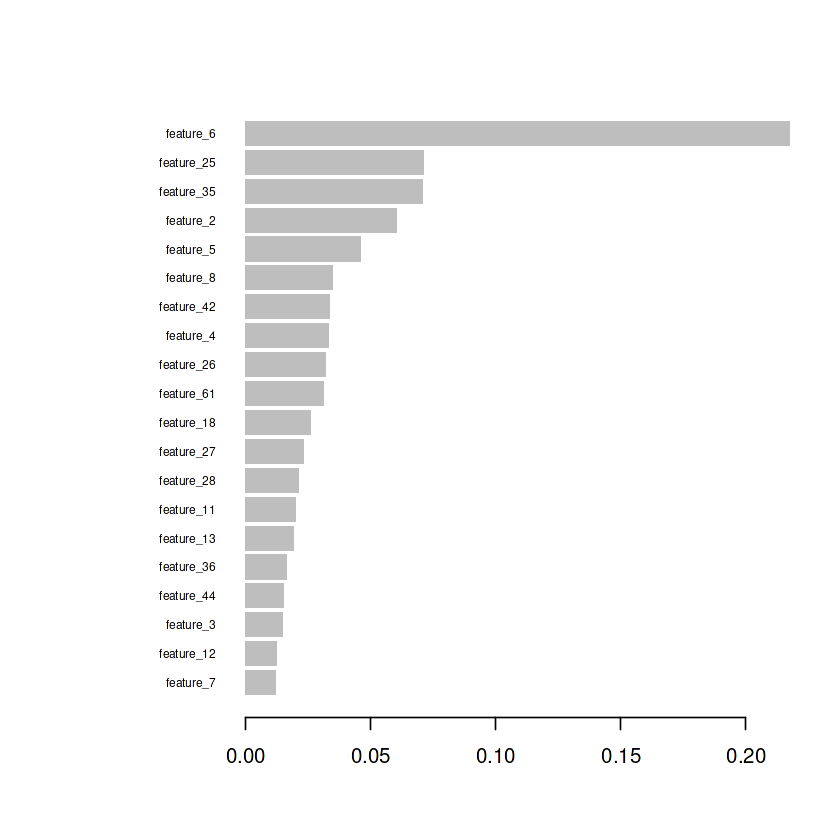

In [4]:
# Prepare DMatrix objects
train_matrix <- xgb.DMatrix(data = as.matrix(train_data_filtered), label = train_labels, weight = train_weights)
validation_matrix <- xgb.DMatrix(data = as.matrix(validation_data_filtered), label = validation_labels)
test_matrix <- xgb.DMatrix(data = as.matrix(test_data_filtered), label = test_labels)

# Set XGBoost parameters
params <- list(
  objective = "multi:softmax",
  num_class = 4,
  eval_metric = c("merror", "mlogloss"),
  max_depth = 6,
  eta = 0.1,
  subsample = 0.8,
  colsample_bytree = 0.8,
  min_child_weight = 1,
  nthread = parallel::detectCores() - 1
)

# Create watchlist for early stopping
watchlist <- list(train = train_matrix, val = validation_matrix)

# Train model with early stopping
xgb_model <- xgb.train(
  params = params,
  data = train_matrix,
  nrounds = 1000,
  watchlist = watchlist,
  early_stopping_rounds = 20,
  verbose = 1
)

# Make predictions on test matrix
test_predictions <- predict(xgb_model, test_matrix)

# Make predictions on train matrix
train_predictions <- predict(xgb_model, train_matrix)

# Evaluate results
cm_test <- confusionMatrix(
  factor(test_predictions, levels = 0:3, labels = levels(full_df$class)),
  factor(test_df$class_numeric, levels = 0:3, labels = levels(full_df$class))
)

# Evaluate results
cm_train <- confusionMatrix(
  factor(train_predictions, levels = 0:3, labels = levels(full_df$class)),
  factor(train_df$class_numeric, levels = 0:3, labels = levels(full_df$class))
)

# Print results
print(cm_test)

cat("\nClass-Specific Statistics:\n")
print(cm_test$byClass)

cat("\nConfusion Matrix Mode:\n")
print(cm_test$mode)

cat("\nAdditional Arguments Passed to confusionMatrix():\n")
print(cm_test$dots)

# Print overall accuracy results
accuracy_test <- cm_test$overall['Accuracy']
accuracy_train <- cm_train$overall['Accuracy']
cat("Final Test Accuracy:", accuracy_test, "\n")
cat("Final Train Accuracy:", accuracy_train, "\n")

feature_names <- colnames(train_data_filtered)
xgb_importance <- xgb.importance(feature_names = feature_names, model = xgb_model)

# Select Top 20 Features
top_20_features <- head(xgb_importance, 20)

# Plot the top 20 features
xgb.plot.importance(top_20_features)

In [5]:
# Define the cost matrix (replace with your actual costs)
cost_matrix <- matrix(
  c(0, 10, 20, 30,   # Benign -> Benign, Early, Pre, Pro
    10, 0, 15, 25,    # Early -> Benign, Early, Pre, Pro
    20, 15, 0, 10,    # Pre -> Benign, Early, Pre, Pro
    30, 25, 10, 0),   # Pro -> Benign, Early, Pre, Pro
  nrow = 4, byrow = TRUE
)
rownames(cost_matrix) <- c("Benign", "Early", "Pre", "Pro")
colnames(cost_matrix) <- c("Benign", "Early", "Pre", "Pro")

# Extract confusion matrix data
cm_table <- cm_test$table
classes <- rownames(cm_table)

visualize_cost_confusion_matrix <- function(cm_test, cost_matrix) {
  # Extract the confusion matrix from caret's result
  cm_table <- cm_test$table
  
  # Create cost-weighted matrix
  cost_weighted_cm <- matrix(0, 
                              nrow = nrow(cost_matrix), 
                              ncol = ncol(cost_matrix))
  
  for (i in 1:nrow(cm_table)) {
    for (j in 1:ncol(cm_table)) {
      if (i != j) {
        cost_weighted_cm[i, j] <- cm_table[i, j] * cost_matrix[i, j]
      }
    }
  }
  
  # Set row and column names
  rownames(cost_weighted_cm) <- rownames(cost_matrix)
  colnames(cost_weighted_cm) <- colnames(cost_matrix)
  
  return(cost_weighted_cm)
}

# Usage
cost_weighted_matrix <- visualize_cost_confusion_matrix(cm_test, cost_matrix)
cat("\nCost-Weighted Misclassification Matrix:\n")
print(cost_weighted_matrix)
    
# Initialize total misclassification cost
total_cost <- 0

# Calculate total misclassification cost by iterating over confusion matrix entries
for (i in 1:nrow(cm_table)) {
  for (j in 1:ncol(cm_table)) {
    if (i != j) {  # Misclassifications (i != j)
      total_cost <- total_cost + cm_table[i, j] * cost_matrix[i, j]
    }
  }
}

# Output the total misclassification cost
cat("Total Misclassification Cost:", total_cost, "\n")

# Calculate average cost per sample
total_samples <- sum(cm_table)
avg_cost_per_sample <- total_cost / total_samples
cat("Average Cost Per Sample:", avg_cost_per_sample, "\n")

# Calculate cost-sensitive accuracy
# Compute the maximum possible cost (if all instances were misclassified to the most costly class)
max_possible_cost <- sum(cost_matrix) * (total_samples / nrow(cost_matrix))
cost_sensitive_accuracy <- 1 - (total_cost / max_possible_cost)
cat("Cost-Sensitive Accuracy:", cost_sensitive_accuracy, "\n")

# Using cost matrix for cost-weighted F1 calculation
f1_scores <- cm_test$byClass[, "F1"]
weights <- 1 / (diag(cost_matrix) + 1)  # Add 1 to avoid divide-by-zero
weights <- weights / sum(weights)
weighted_f1 <- sum(f1_scores * weights, na.rm = TRUE)
cat("Weighted F1-score", weighted_f1, "\n")

# Save the trained model
xgb.save(xgb_model, "xgb_model.model")


Cost-Weighted Misclassification Matrix:


       Benign Early Pre Pro
Benign      0    20   0   0
Early     100     0  90   0
Pre        20    30   0   0
Pro        90     0  30   0


Total Misclassification Cost: 380 


Average Cost Per Sample: 0.7335907 


Cost-Sensitive Accuracy: 0.986662 


Weighted F1-score 0.9419104 


[1] TRUE